In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.one_hot import OneHotEncoder
import random
random.seed(0)

In [2]:
info = pd.read_csv('data/heroes_information.csv')
powers = pd.read_csv('data/super_hero_powers.csv')

df = pd.merge(info,powers,left_on='name',right_on='hero_names',how='inner').drop(columns='Unnamed: 0')
del powers, info

In [3]:
cols = ['name','hero_names']
df = df.drop(columns=cols).fillna(0)
df['Alignment'] = df['Alignment'].replace('good',1).replace('bad',0).replace('-',0).replace('neutral',1)

In [4]:
df.shape

(660, 176)

In [5]:
cols_enc = ['Gender','Eye color', 'Race', 'Hair color','Skin color','Publisher']

ohe = OneHotEncoder(use_cat_names=True,cols=cols_enc)

df = ohe.fit_transform(df).drop(columns='Gender_Male')

/Users/cmougan/opt/anaconda3/envs/superhero/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [6]:
df.shape

(660, 328)

In [7]:
for col in df.columns:
    if df[col].dtypes != object:
        if df[col].sum() < 50:
            df.drop(col, inplace=True, axis=1)
        else:
            df[col] = df[col].astype(int)

In [8]:
df.shape

(660, 50)

# Machine Learning

## Label Engineering

In [9]:
df['label'] = df['Alignment']*df['Super Strength']*df['Super Speed']
df = df.drop(columns=['Super Strength'])
df = df.drop(columns=['Super Speed'])
df = df.drop(columns=['Alignment'])

In [10]:
df.label.value_counts()

0    510
1    150
Name: label, dtype: int64

In [11]:
X = df.drop(columns='label')
y = df[['label']]

In [12]:
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score,classification_report
import shap
from tqdm import tqdm
import xgboost

In [13]:
%%time
loo = LeaveOneOut()
res = []
rf = RandomForestClassifier(n_estimators=20)
for train, test in tqdm(loo.split(X)):
    X_train, X_test, y_train, y_test = (
        X.values[train],
        X.values[test],
        y.values[train].ravel(),
        y.values[test].ravel(),
    )
    rf.fit(X_train, y_train)
    res.append([rf.predict_proba(X_test)[:, 1][0], y_test[0]])

660it [00:23, 27.71it/s]

CPU times: user 21.9 s, sys: 534 ms, total: 22.4 s
Wall time: 23.8 s


In [14]:
df['preds'] =pd.DataFrame(res,columns = ['preds','real']).preds
df['real'] =pd.DataFrame(res,columns = ['preds','real']).real

In [15]:
print('Model score on LOOCV:',roc_auc_score(df.real,df.preds))

Model score on LOOCV: 0.8166666666666667


In [16]:
print(classification_report(df.real,df.preds>0.5))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87       510
           1       0.58      0.27      0.37       150

    accuracy                           0.79       660
   macro avg       0.70      0.61      0.62       660
weighted avg       0.76      0.79      0.76       660



In [17]:
print('GENDER FEMALE')
print(classification_report(df[df['Gender_Female']==1].real,df[df['Gender_Female']==1].preds>0.5))
print('GENDER MALE')
print(classification_report(df[df['Gender_Female']==0].real,df[df['Gender_Female']==0].preds>0.5))

GENDER FEMALE
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       135
           1       0.55      0.28      0.37        43

    accuracy                           0.77       178
   macro avg       0.67      0.60      0.61       178
weighted avg       0.74      0.77      0.74       178

GENDER MALE
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       375
           1       0.59      0.27      0.37       107

    accuracy                           0.80       482
   macro avg       0.71      0.61      0.63       482
weighted avg       0.77      0.80      0.77       482



In [18]:
print('RACE HUMAN')
print(classification_report(df[df['Race_Human']==1].real,df[df['Race_Human']==1].preds>0.5))
print('RACE MUTANT')
print(classification_report(df[df['Race_Mutant']==0].real,df[df['Race_Mutant']==0].preds>0.5))

RACE HUMAN
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       152
           1       0.65      0.35      0.45        43

    accuracy                           0.82       195
   macro avg       0.74      0.65      0.67       195
weighted avg       0.80      0.82      0.79       195

RACE MUTANT
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       460
           1       0.58      0.28      0.37       138

    accuracy                           0.79       598
   macro avg       0.70      0.61      0.62       598
weighted avg       0.76      0.79      0.76       598



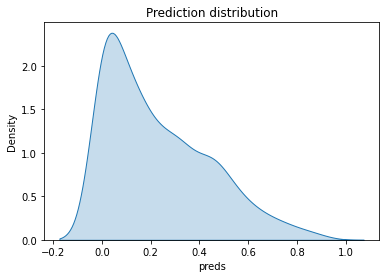

In [19]:
plt.figure()
plt.title('Prediction distribution')
sns.kdeplot(df.preds,fill=True)
plt.show()

In [20]:
selected = df.sort_values('preds',ascending=False).head(50)

In [21]:
print('Percentage of male in top 50:',selected['Gender_Female'].value_counts(normalize=True)[0])
print('Percentage of male in all',np.round(df['Gender_Female'].value_counts(normalize=True)[0],decimals=2))

Percentage of male in top 50: 0.72
Percentage of male in all 0.73


In [22]:
print('Percentage of Humans',selected['Race_Human'].value_counts(normalize=True)[0])
print('Percentage of Humans in all',np.round(df['Race_Human'].value_counts(normalize=True)[0],decimals=2))

Percentage of Humans 0.68
Percentage of Humans in all 0.7


## Shap values

[20:59:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


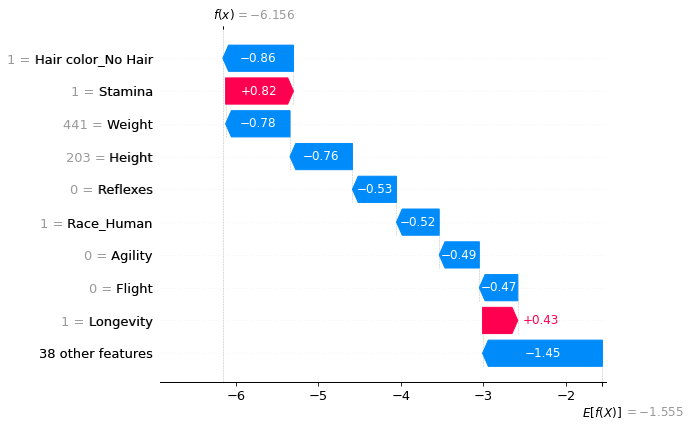

In [23]:
model = xgboost.XGBClassifier().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

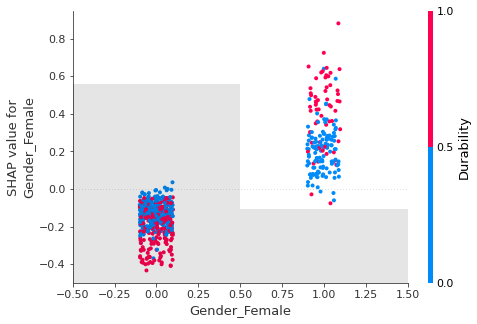

In [24]:
shap.plots.scatter(shap_values[:,"Gender_Female"], color=shap_values)

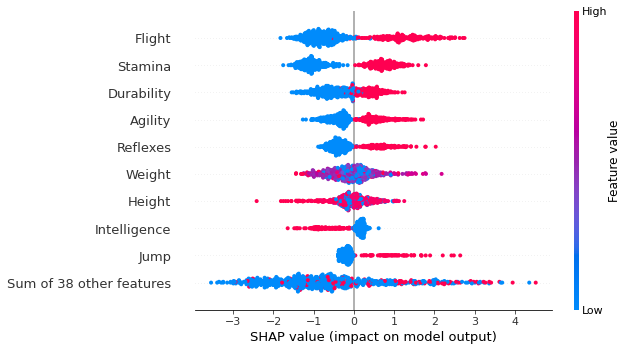

In [25]:
shap.plots.beeswarm(shap_values)

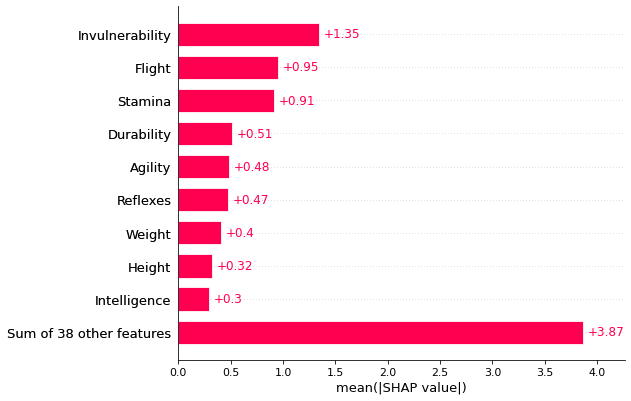

In [26]:
shap.plots.bar(shap_values)

## Predicting Gender

In [36]:
new_X = X.copy()
new_X['prev_target'] = y

new_y = new_X['Gender_Female']
new_X = X.drop(columns='Gender_Female')

In [37]:
new_X = new_X.drop(columns=['Weight','Height','Stamina'])

In [50]:
model = RandomForestRegressor(n_estimators=20,max_depth=5,bootstrap=True).fit(new_X, new_y)


In [51]:
#print('Model score on LOOCV:',roc_auc_score(new_y,model.predict_proba(new_X)[:,1]))
print('Model score on LOOCV:',roc_auc_score(new_y,model.predict(new_X)))

Model score on LOOCV: 0.8534255676255303


In [46]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(new_X)

# visualize the first prediction's explanation
#shap.plots.waterfall(shap_values[0])

In [47]:
#shap.plots.scatter(shap_values[:,"Gender_Female"], color=shap_values)

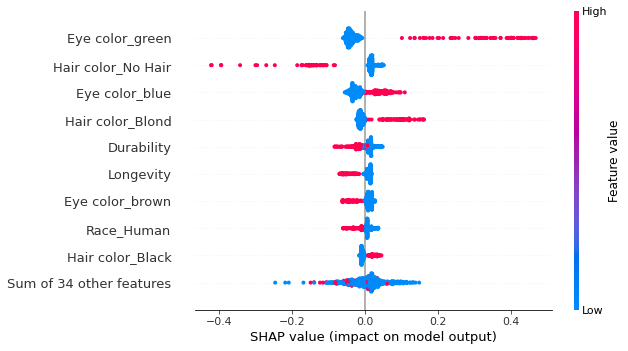

In [48]:
shap.plots.beeswarm(shap_values)

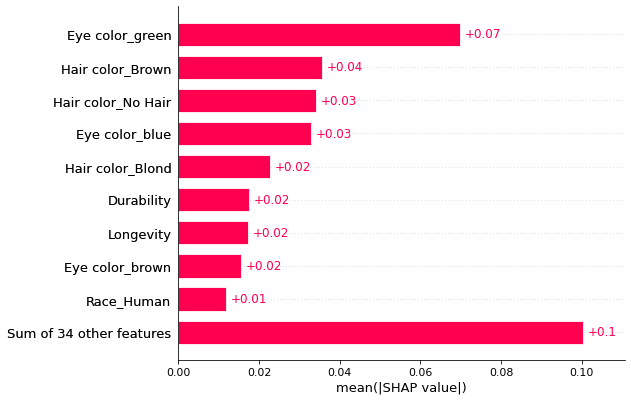

In [49]:
shap.plots.bar(shap_values)